In [55]:
import itertools
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)
import time

import jax
import jax.numpy as jnp
import jax.nn as nn
from jax import random, vmap, jit, grad
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.special import roots_legendre
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import trange

from pycbem.field import efield, hfield, poynting
from pycbem.utils.dataloader import (load_antenna_el_properties,
                                     load_sphere_coords)

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
data = load_sphere_coords(2312)
data.head()

,x,y,z
0,-0.049703,-0.051179,0.050094
1,0.049703,-0.051179,-0.050094
2,-0.050094,-0.051179,-0.049703
3,0.050094,-0.051179,0.049703
4,-0.049653,0.053037,0.048751


In [91]:
# effective radiated skin area
target_area = (2 / 100, 2 / 100)
A = target_area[0] * target_area[1]  # irradiated area
d = -5 / 1000  # distance from the antenna
target_area_origin = (-target_area[0]/2, -target_area[1]/2)

In [4]:
data_target = data[
    (data['y'] < 0) &
    (data['x'] > target_area_origin[0]) &
    (data['x'] < target_area_origin[0] * -1) &
    (data['z'] > target_area_origin[1]) &
    (data['z'] < target_area_origin[1] * -1)]
data_target.reset_index(drop=True, inplace=True)
data_target.head()

,x,y,z
0,-0.009562,-0.088281,0.009294
1,0.009562,-0.088281,-0.009294
2,0.009294,-0.088281,0.009562
3,-0.009294,-0.088281,-0.009562
4,-0.008688,-0.088457,0.008554


In [59]:
# antenna electric properties (Poljak 2005)
d = - 5 / 1000  # antenna-to-surface distance
f = 10e9  # operating frequency
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
xs = antenna_data.x.to_numpy()
xs = xs - xs.max() / 2
ys = np.zeros_like(xs) + data_target['y'].min() + d
zs = np.zeros_like(xs)

In [5]:
X = data_target[['x', 'z']].to_numpy()
y = data_target['y'].to_numpy()

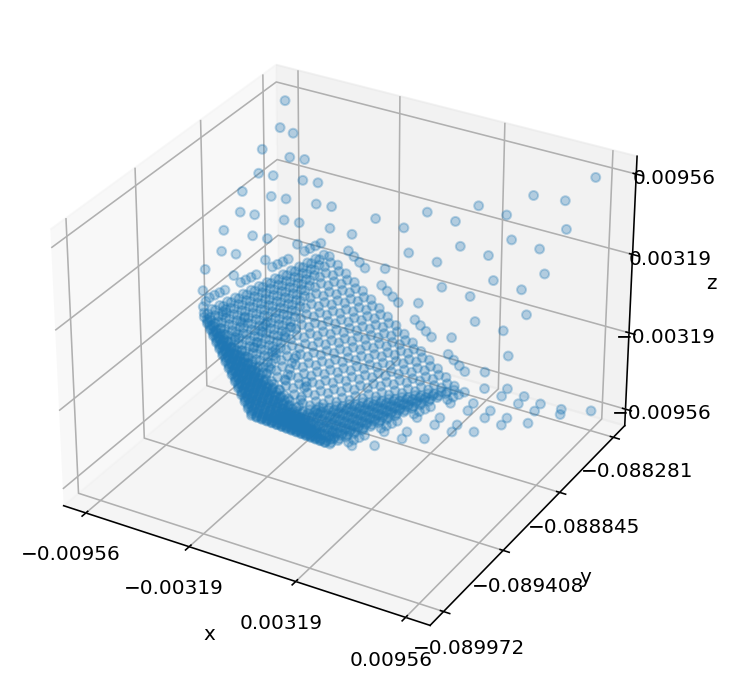

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=np.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=np.mgrid[y.min():y.max():4j],
       zticks=np.mgrid[X[:, 1].min():X[:, 1].max():4j]);

In [7]:
def cart2sph(x, y, z):
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return x, y, z

In [8]:
_, theta, phi = cart2sph(X[:, 0], y, X[:, 1])
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
theta_points, theta_weights = roots_legendre(100)
phi_points, phi_weights = roots_legendre(100)
theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
phi_weights = 0.5 * phi_weights * (phi_b - phi_a)

r = 0.09
phi_grid, theta_grid = np.meshgrid(phi_points, theta_points)
xt, yt, zt = sph2cart(r, theta_grid.ravel(), phi_grid.ravel())

In [9]:
X = np.hstack((xt.reshape(-1, 1), zt.reshape(-1, 1)))
y = np.array(yt).reshape(-1, 1)

In [10]:
X_scaled = X * 100
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

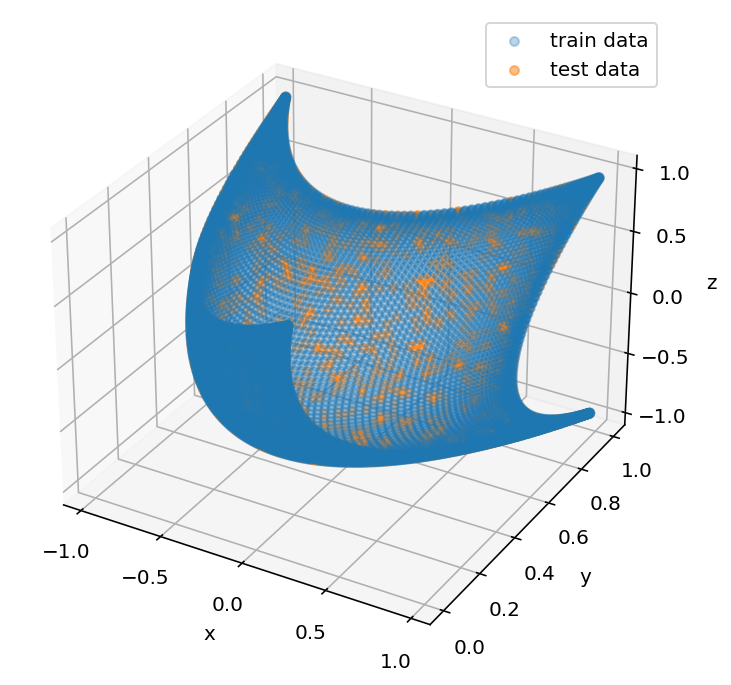

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_train[:, 0], y_train, X_train[:, 1], c='C0', label='train data', alpha=0.3)
ax.scatter(X_test[:, 0], y_test, X_test[:, 1], c='C1', label='test data', alpha=0.5)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=np.mgrid[-1:1:5j], zticks=np.mgrid[-1:1:5j])
ax.legend();

In [13]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

In [14]:
rng = random.PRNGKey(0)


def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return (scale * random.normal(w_key, (n, m)),
                scale * random.normal(b_key, (n, )))
    return [random_layer_params(m, n, key)
            for m, n, key in zip(sizes[:-1], sizes[1:], keys)]


def forward(params, X):
    output = X
    for w, b in params[:-1]:
        output = nn.relu(w @ output + b)
    w, b = params[-1]
    output = w @ output + b
    return output


batch_forward = vmap(forward, in_axes=(None, 0))


@jit
def loss_fn(params, batch):
    X, y = batch
    y_pred = batch_forward(params, X)
    return jnp.sum(jnp.square(y_pred - y))


grad_fn = jit(grad(loss_fn))


@jit
def update(step, optim_state, batch):
    params = optim_params(optim_state)
    grads = grad_fn(params, batch)
    optim_state = optim_update(step, grads, optim_state)
    return optim_state


def data_stream(num_train, num_batches):
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X_train[batch_idx], y_train[batch_idx]

In [15]:
step_size = 0.001
n_epochs = 500
printout = int(n_epochs / 10.)
batch_size = 128
# momentum_mass = 0.9  # for momentum and adagrad
sizes = [2, 30, 60, 30, 1]

num_train = X_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

batches = data_stream(num_train, num_batches)

optim_init, optim_update, optim_params = optimizers.adam(step_size)
init_params = init_network_params(sizes, rng)
optim_state = optim_init(init_params)
itercount = itertools.count()

loss_train, loss_test = [], []
for epoch in trange(n_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        optim_state = update(next(itercount), optim_state, next(batches))
    epoch_time = time.time() - start_time
    
    params = optim_params(optim_state)
    if (epoch == 0) or (epoch % printout == (printout - 1)):
        if epoch == 0:
            print('epoch \t| loss on test set')
            print('----- \t| ----------------')
        loss_train.append(loss_fn(params, (X_train, y_train)))
        l = loss_fn(params, (X_test, y_test))
        loss_test.append(l)
        print(f'{epoch + 1} \t| {l}')

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 	| loss on test set
----- 	| ----------------
1 	| 177.2463836669922
50 	| 0.09002415835857391
100 	| 0.07207483798265457
150 	| 0.023503625765442848
200 	| 0.020379487425088882
250 	| 0.02174924686551094
300 	| 0.017367176711559296
350 	| 0.01764298416674137
400 	| 0.02852969989180565
450 	| 0.04202903434634209
500 	| 0.013222756795585155


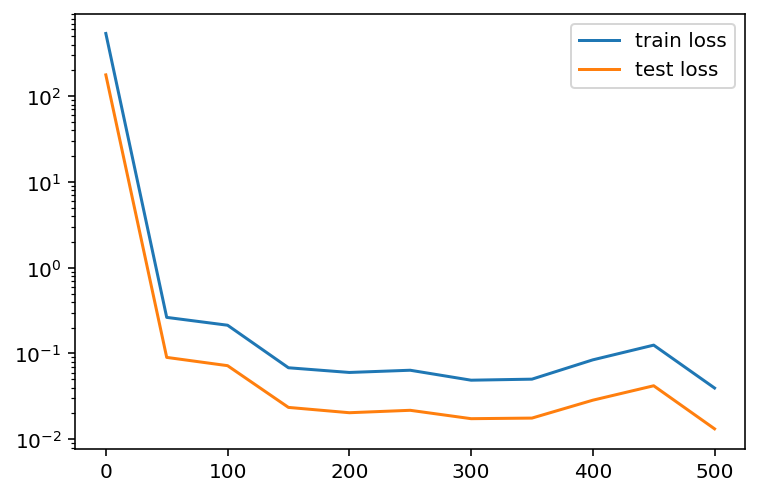

In [16]:
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_train, label='train loss')
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_test, label='test loss')
plt.yscale('log')
plt.legend();

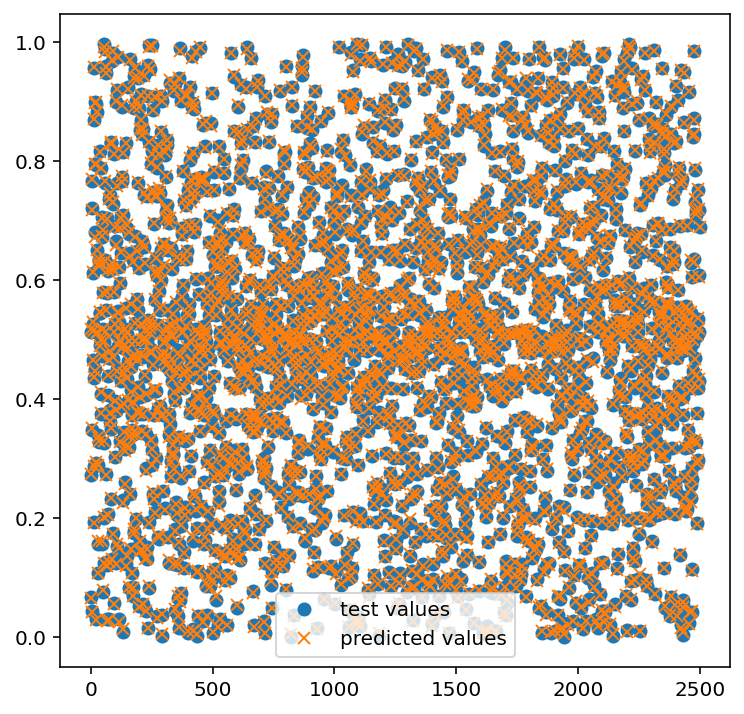

In [17]:
fig = plt.figure(figsize=(6, 6))
plt.plot(y_test.flatten(), 'o', label='test values')
plt.plot(batch_forward(params, X_test).flatten(), 'x', label='predicted values')
plt.legend();

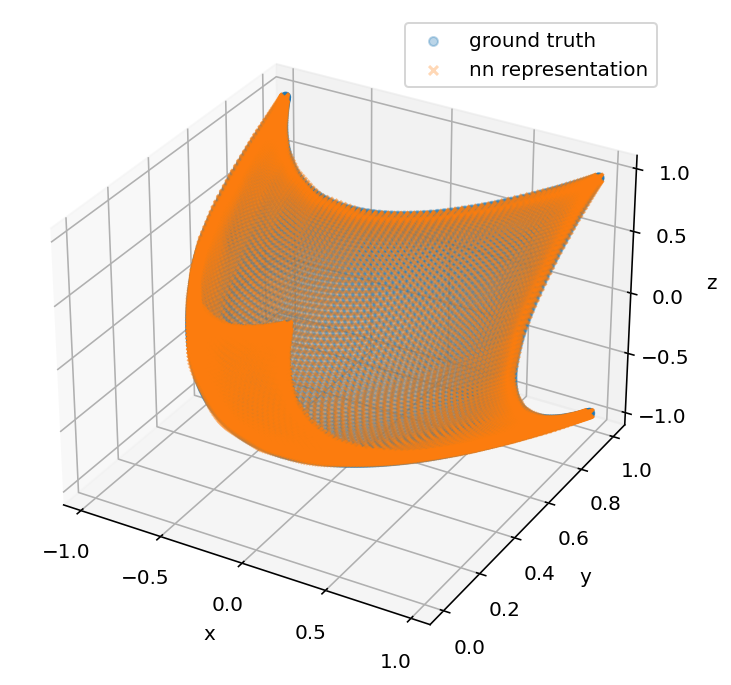

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_scaled[:, 0], y_scaled, X_scaled[:, 1], alpha=0.3, label='ground truth')
ax.scatter(X_scaled[:, 0], batch_forward(params, X_scaled), X_scaled[:, 1], marker='x', alpha=0.3, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[-1:1:5j], zticks=jnp.mgrid[-1:1:5j])
ax.legend();

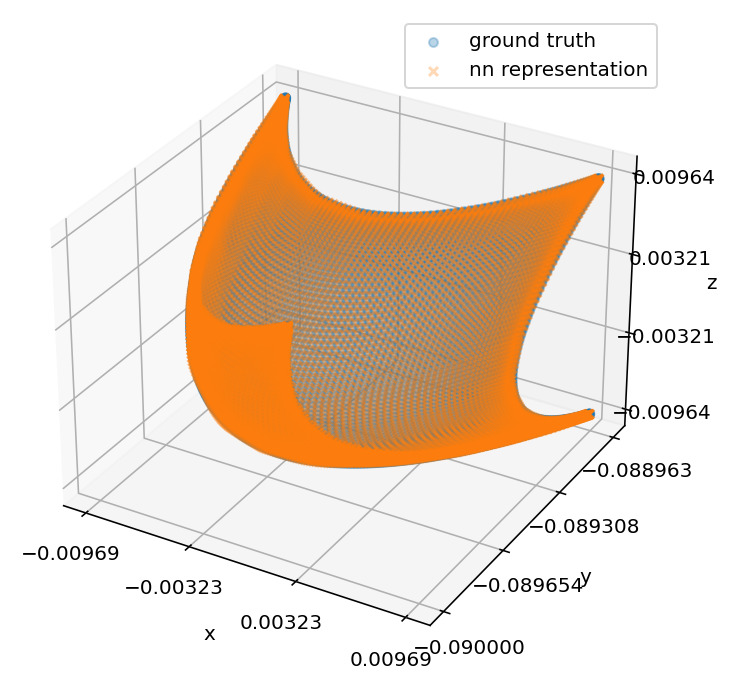

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3, label='ground truth')
ax.scatter(X[:, 0], scaler.inverse_transform(batch_forward(params, X_scaled)), X[:, 1], marker='x', alpha=0.3, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=np.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=np.mgrid[y.min():y.max():4j],
       zticks=np.mgrid[X[:, 1].min():X[:, 1].max():4j]);
ax.legend();

In [53]:
def y_nn(X):
    return forward(params, X * 100)[0]


grad_y_nn = jit(vmap(grad(y_nn)))

In [54]:
x_a = X[:, 0].min()
x_b = X[:, 0].max()
z_a = X[:, 1].min()
z_b = X[:, 1].max()
x_points, x_weights = roots_legendre(33)
z_points, z_weights = roots_legendre(33)
x_points = 0.5 * (x_points + 1.) * (x_b - x_a) + x_a
x_weights = 0.5 * x_weights * (x_b - x_a)
z_points = 0.5 * (z_points + 1.) * (z_b - z_a) + z_a
z_weights = 0.5 * z_weights * (z_b - z_a)

In [92]:
xt_list, yt_list, zt_list = [], [], []
poynting_mag = 0
S_list = []
for xt, w_xt in zip(x_points, x_weights):
    for zt, w_zt in zip(z_points, z_weights):
        xtzt = jnp.atleast_2d(jnp.r_[xt, zt])
        yt_scaled = batch_forward(params, xtzt)
        yt = scaler.inverse_transform(yt_scaled)[0][0]
        grad_yt_scaled = grad_y_nn(xtzt)
        Sx, Sy, Sz = poynting(xt, yt, zt, xs, ys, zs, Is, f)
        S = np.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2)
        S_list.append(S)
        dA = 1  # to implement
        poynting_mag +=  np.real(S) * w_xt * w_zt * dA
Sab = poynting_mag / (2 * A)

In [95]:
Sx

(1.529841231142393-1.5564825713232662j)

In [96]:
Sab

6.564604158445332